In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install kaggle==1.5.12

     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=df0a9d9d45358102be090ed682f3783036b7138a0ca88116daf5822266c9a863
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [ ]:
!kaggle --version 

Kaggle API 1.5.12


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/APTOS/

/content/drive/MyDrive/APTOS


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [03:46<00:00, 28.8MB/s]
100% 9.51G/9.51G [03:46<00:00, 45.0MB/s]


In [ ]:
zipData = "/content/drive/MyDrive/APTOS/aptos2019-blindness-detection.zip"
data = "/content/drive/MyDrive/APTOS/data"

In [ ]:
import zipfile
with zipfile.ZipFile(zipData, 'r') as zip_ref:
    zip_ref.extractall(data)

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.6.0
/device:GPU:0
Num GPUs Available:  1


# Data Preprocessing

In [ ]:
data = "/content/drive/MyDrive/APTOS/data"
alv_data =  "/content/drive/MyDrive/APTOS-alvee/APTOS/data"

In [ ]:
data = data

In [ ]:
train_df = pd.read_csv(data+'/train.csv')
test_df = pd.read_csv(data+'/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

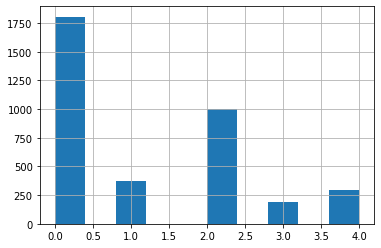

In [ ]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

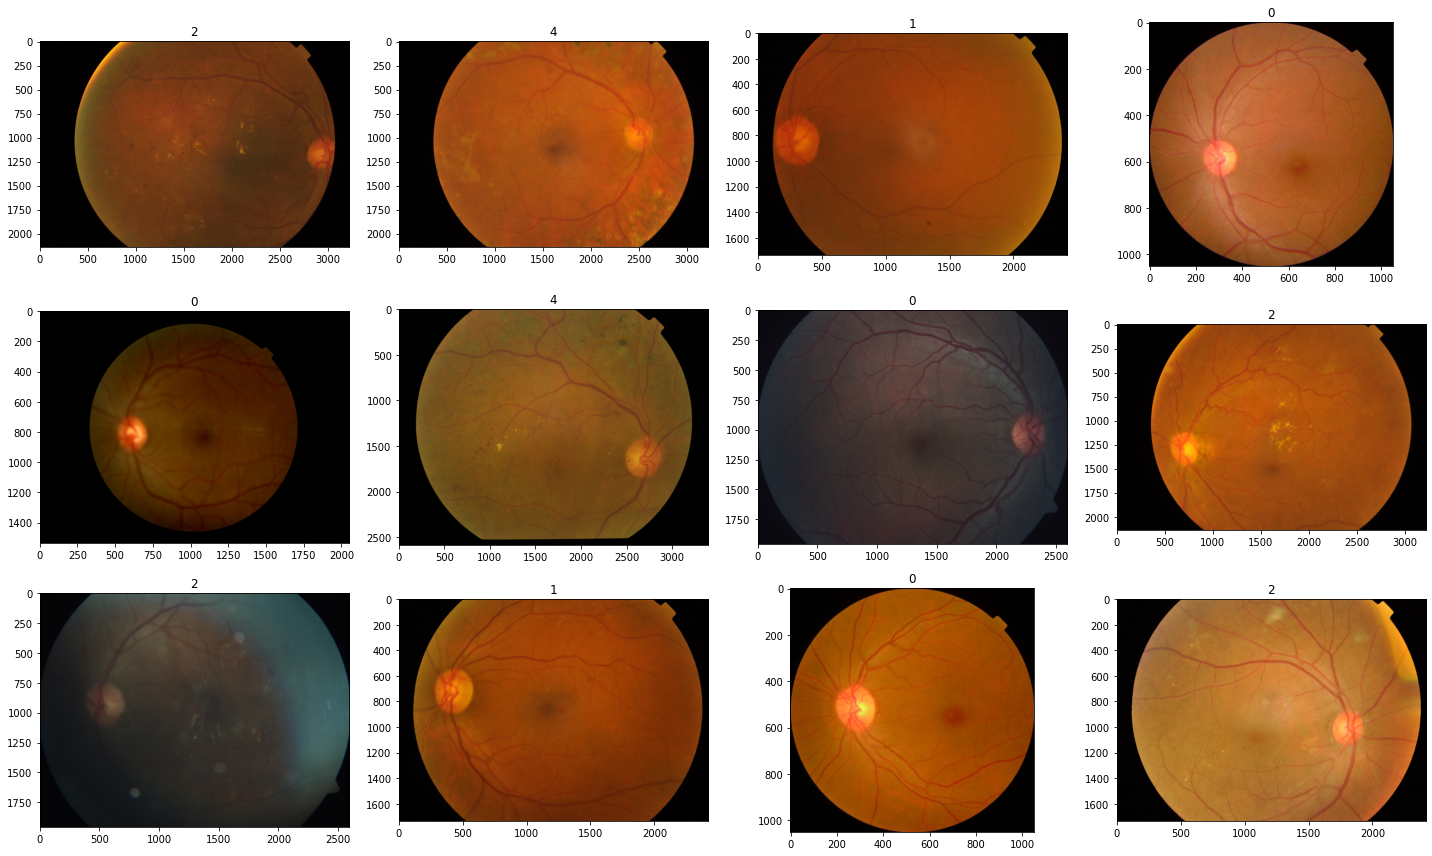

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(data+f'/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [ ]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [ ]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        data+f'/train_images/{image_id}.png'
    )

In [ ]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        data+f'/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [10:39<00:00,  3.01it/s]


### Saving X Test and X Train

In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/APTOS/

/content/drive/MyDrive/APTOS


In [ ]:
%cd /content/drive/MyDrive/APTOS-alvee/APTOS/

/content/drive/.shortcut-targets-by-id/13_38BwAQFcG6IaSZSWLk6Juv6oKwye3v/APTOS


In [ ]:
import h5py

with h5py.File('xtrain-aptos.h5', 'w') as hf:
  hf.create_dataset('x_train', data = x_train)

with h5py.File('xtest-aptos.h5', 'w') as hf:
  hf.create_dataset('x_test', data = x_test)

In [ ]:
# Loading the data
import h5py

with h5py.File('xtrain-aptos.h5', 'r') as hf:
  x_train = hf['x_train'][:]
with h5py.File('xtest-aptos.h5', 'r') as hf:
  x_test = hf['x_test'][:]

In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [ ]:
x_train_mod, x_val_mod, y_train_mod, y_val_mod = train_test_split(
    x_train, train_df['diagnosis'], 
    test_size=0.15, 
    random_state=2019
)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [ ]:
BATCH_SIZE = 32

def create_datagen():
  with tf.device('/device:GPU:0'):
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [ ]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [ ]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

# Building Model With Preloaded Weights

In [ ]:
filepath = "/content/drive/MyDrive/APTOS/best_weights"

In [ ]:
alv_filepath = "/content/drive/MyDrive/APTOS-alvee/APTOS/best_weights"
filepath = alv_filepath

### DenseNet121

In [ ]:
densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3)
)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
# Checkpoint to save the best weights for DenseNet
checkpoint_filepath = filepath + '/densenet.h5'
dense_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
def fit_model():
  with tf.device('/device:GPU:0'):
    dense_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=2,
        validation_data=(x_val, y_val),
        callbacks =[dense_checkpoint_callback]
    )
    return dense_history

In [ ]:
denseNet_hist = fit_model()

Epoch 1/2
97/97 [==============================] - 100s 855ms/step - loss: 0.2482 - accuracy: 0.8136 - precision_5: 0.8869 - recall_5: 0.8664 - val_loss: 0.4973 - val_accuracy: 0.9218 - val_precision_5: 0.9724 - val_recall_5: 0.7778
Epoch 2/2
97/97 [==============================] - 77s 790ms/step - loss: 0.1543 - accuracy: 0.7815 - precision_5: 0.9417 - recall_5: 0.9094 - val_loss: 0.1992 - val_accuracy: 0.7055 - val_precision_5: 0.9428 - val_recall_5: 0.9162


### Xception

In [ ]:
xception= tf.keras.applications.Xception(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3)
)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for Xception
checkpoint_filepath = filepath + '/xception.h5'
xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_xception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(xception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_xception_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
def fit_xception_model():
  with tf.device('/device:GPU:0'):
    xception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=2,
        validation_data=(x_val, y_val),
        callbacks = [xception_checkpoint_callback]
    )
    return xception_history

In [ ]:
xception_hist = fit_xception_model()

Epoch 1/2
97/97 [==============================] - 151s 1s/step - loss: 0.1893 - accuracy: 0.9113 - precision_4: 0.9297 - recall_4: 0.8936 - val_loss: 0.2575 - val_accuracy: 0.9891 - val_precision_4: 0.9496 - val_recall_4: 0.8633
Epoch 2/2
97/97 [==============================] - 139s 1s/step - loss: 0.1376 - accuracy: 0.9229 - precision_4: 0.9476 - recall_4: 0.9192 - val_loss: 0.1454 - val_accuracy: 0.8873 - val_precision_4: 0.9536 - val_recall_4: 0.9427


### ResNet50

In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for resnet
checkpoint_filepath = filepath + '/resnet50.h5'
resnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_resnet_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_resnet_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def fit_resnet_model():
  with tf.device('/device:GPU:0'):
    resnet_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=2,
        validation_data=(x_val, y_val),
        callbacks = [resnet_checkpoint_callback]
    )
    return resnet_history

In [ ]:
resnet_hist = fit_resnet_model()

Epoch 1/2
97/97 [==============================] - 88s 800ms/step - loss: 0.2348 - accuracy: 0.8695 - precision_3: 0.9174 - recall_3: 0.8706 - val_loss: 380.7325 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 0.4850
Epoch 2/2
97/97 [==============================] - 74s 763ms/step - loss: 0.1678 - accuracy: 0.8531 - precision_3: 0.9410 - recall_3: 0.9029 - val_loss: 0.3742 - val_accuracy: 0.6527 - val_precision_3: 0.8199 - val_recall_3: 0.8951


### VGG16

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for vgg16
checkpoint_filepath = filepath + '/vgg16.h5'
vgg16_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg16_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg16)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg16_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg16_model():
  with tf.device('/device:GPU:0'):
    vgg16_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=2,
        validation_data=(x_val, y_val),
        callbacks = [vgg16_checkpoint_callback]
    )
    return vgg16_history

In [ ]:
vgg16_hist = fit_vgg16_model()

Epoch 1/2
97/97 [==============================] - 136s 910ms/step - loss: 0.7134 - accuracy: 0.9781 - precision: 0.7862 - recall: 0.7273 - val_loss: 0.3062 - val_accuracy: 1.0000 - val_precision: 0.8770 - val_recall: 0.8801
Epoch 2/2
97/97 [==============================] - 81s 830ms/step - loss: 0.3476 - accuracy: 0.9994 - precision: 0.8343 - recall: 0.8239 - val_loss: 0.3133 - val_accuracy: 1.0000 - val_precision: 0.9865 - val_recall: 0.5802


### VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for vgg19
checkpoint_filepath = filepath + '/vgg19.h5'
vgg19_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg19_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg19)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg19_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 20,026,949
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg19_model():
  with tf.device('/device:GPU:0'):
    vgg19_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=2,
        validation_data=(x_val, y_val),
        callbacks = [vgg19_checkpoint_callback]
    )
    return vgg19_history

In [ ]:
vgg19_hist = fit_vgg19_model()

Epoch 1/2
97/97 [==============================] - 97s 982ms/step - loss: 1.3790 - accuracy: 0.9894 - precision_1: 0.7605 - recall_1: 0.6589 - val_loss: 0.4658 - val_accuracy: 1.0000 - val_precision_1: 0.6234 - val_recall_1: 0.9065
Epoch 2/2
97/97 [==============================] - 95s 972ms/step - loss: 0.4588 - accuracy: 0.9974 - precision_1: 0.7743 - recall_1: 0.6448 - val_loss: 0.3970 - val_accuracy: 1.0000 - val_precision_1: 0.7904 - val_recall_1: 0.7152


### Inception


In [ ]:
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Checkpoint to save the best weights for Inception
checkpoint_filepath = filepath + '/inception.h5'
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_inception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(inception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_inception_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
def fit_inception_model():
  with tf.device('/device:GPU:0'):
    inception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=2,
        validation_data=(x_val, y_val),
        callbacks = [inception_checkpoint_callback]
    )
    return inception_history

In [ ]:
inception_hist = fit_inception_model()

Epoch 1/2
97/97 [==============================] - 77s 667ms/step - loss: 0.2178 - accuracy: 0.8924 - precision_2: 0.9224 - recall_2: 0.8661 - val_loss: 1.4619 - val_accuracy: 0.6091 - val_precision_2: 0.7405 - val_recall_2: 0.8783
Epoch 2/2
97/97 [==============================] - 59s 609ms/step - loss: 0.1653 - accuracy: 0.8612 - precision_2: 0.9395 - recall_2: 0.9032 - val_loss: 0.3462 - val_accuracy: 0.9964 - val_precision_2: 0.7922 - val_recall_2: 0.8942


## Visualization

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

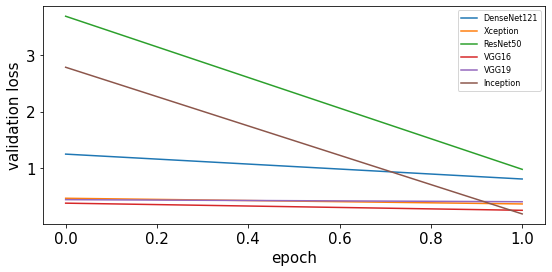

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_loss'])
plt.plot(xception_hist.history['val_loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.plot(vgg16_hist.history['val_loss'])
plt.plot(vgg19_hist.history['val_loss'])
plt.plot(inception_hist.history['val_loss'])
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

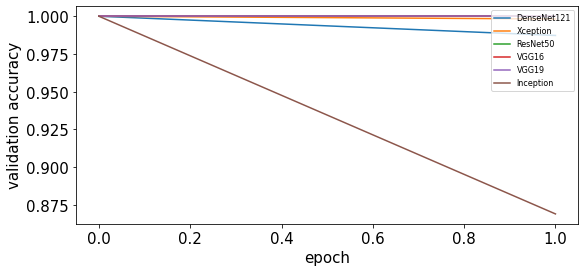

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_accuracy'])
plt.plot(xception_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(vgg16_hist.history['val_accuracy'])
plt.plot(vgg19_hist.history['val_accuracy'])
plt.plot(inception_hist.history['val_accuracy'])
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
xception_hist.history

{'accuracy': [0.8884961605072021, 0.9733290672302246],
 'loss': [0.19109489023685455, 0.13752126693725586],
 'precision_14': [0.927563488483429, 0.9445213079452515],
 'val_accuracy': [1.0, 0.9127272963523865],
 'val_loss': [0.5322237014770508, 0.1626356989145279],
 'val_precision_14': [0.9635258316993713, 0.8867313861846924]}

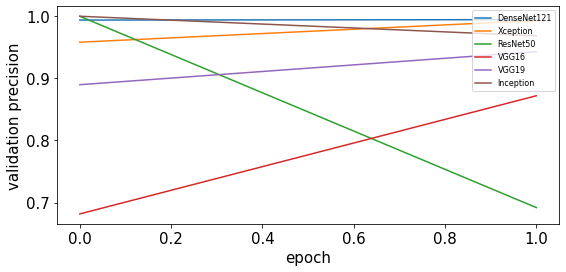

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_precision'])
plt.plot(xception_hist.history['val_precision_1'])
plt.plot(resnet_hist.history['val_precision_2'])
plt.plot(vgg16_hist.history['val_precision_3'])
plt.plot(vgg19_hist.history['val_precision_4'])
plt.plot(inception_hist.history['val_precision_5'])
plt.ylabel('validation precision')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

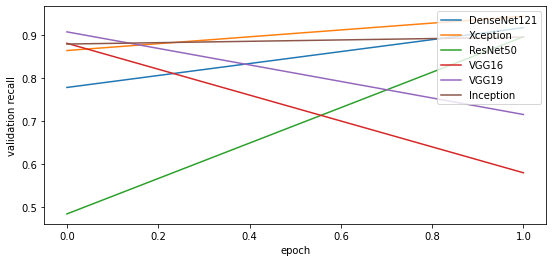

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_recall_5'])
plt.plot(xception_hist.history['val_recall_4'])
plt.plot(resnet_hist.history['val_recall_3'])
plt.plot(vgg16_hist.history['val_recall'])
plt.plot(vgg19_hist.history['val_recall_1'])
plt.plot(inception_hist.history['val_recall_2'])
plt.ylabel('validation recall')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

# Building Model With Random Initialization of Weights

In [ ]:
import pickle

### DenseNet121

In [ ]:
filepath = "/content/drive/MyDrive/APTOS/best_weights_rand"

In [ ]:
history_filepath = "/content/drive/MyDrive/APTOS/best_weights_rand/history"

In [ ]:
densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for DenseNet
checkpoint_filepath = filepath + '/densenet.h5'
dense_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
def fit_model():
  with tf.device('/device:GPU:0'):
    dense_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks =[dense_checkpoint_callback]
    )
    return dense_history

In [ ]:
denseNet_hist = fit_model()

Epoch 1/5
97/97 [==============================] - 93s 815ms/step - loss: 0.3227 - accuracy: 0.9730 - precision_6: 0.8695 - recall_6: 0.8099 - val_loss: 8.1245 - val_accuracy: 1.0000 - val_precision_6: 0.9928 - val_recall_6: 0.4868
Epoch 2/5
97/97 [==============================] - 77s 790ms/step - loss: 0.2679 - accuracy: 0.9997 - precision_6: 0.9071 - recall_6: 0.8409 - val_loss: 5.2861 - val_accuracy: 1.0000 - val_precision_6: 0.9982 - val_recall_6: 0.4868
Epoch 3/5
97/97 [==============================] - 77s 788ms/step - loss: 0.2491 - accuracy: 1.0000 - precision_6: 0.9110 - recall_6: 0.8476 - val_loss: 1.0231 - val_accuracy: 1.0000 - val_precision_6: 0.8296 - val_recall_6: 0.7601
Epoch 4/5
97/97 [==============================] - 77s 787ms/step - loss: 0.2527 - accuracy: 0.9997 - precision_6: 0.9144 - recall_6: 0.8478 - val_loss: 3.1008 - val_accuracy: 1.0000 - val_precision_6: 0.9859 - val_recall_6: 0.4929
Epoch 5/5
97/97 [==============================] - 77s 788ms/step - loss

In [ ]:
np.save(history_filepath +'/denseNet_hist.npy', denseNet_hist.history) 

### Xception

In [ ]:
xception= tf.keras.applications.Xception(
    include_top=False, weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for Xception
checkpoint_filepath = filepath + '/xception.h5'
xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_xception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(xception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_xception_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
def fit_xception_model():
  with tf.device('/device:GPU:0'):
    xception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [xception_checkpoint_callback]
    )
    return xception_history

In [ ]:
xception_hist = fit_xception_model()

Epoch 1/5
97/97 [==============================] - 145s 1s/step - loss: 0.3044 - accuracy: 0.9891 - precision_7: 0.8693 - recall_7: 0.8326 - val_loss: 0.5828 - val_accuracy: 1.0000 - val_precision_7: 0.7400 - val_recall_7: 0.7178
Epoch 2/5
97/97 [==============================] - 139s 1s/step - loss: 0.2595 - accuracy: 1.0000 - precision_7: 0.9130 - recall_7: 0.8422 - val_loss: 0.4903 - val_accuracy: 1.0000 - val_precision_7: 0.7459 - val_recall_7: 0.7143
Epoch 3/5
97/97 [==============================] - 139s 1s/step - loss: 0.2512 - accuracy: 1.0000 - precision_7: 0.9201 - recall_7: 0.8494 - val_loss: 0.4826 - val_accuracy: 1.0000 - val_precision_7: 0.6288 - val_recall_7: 0.9039
Epoch 4/5
97/97 [==============================] - 138s 1s/step - loss: 0.2463 - accuracy: 1.0000 - precision_7: 0.9213 - recall_7: 0.8475 - val_loss: 0.5438 - val_accuracy: 1.0000 - val_precision_7: 0.6236 - val_recall_7: 0.9056
Epoch 5/5
97/97 [==============================] - 139s 1s/step - loss: 0.2444 -

In [ ]:
np.save(history_filepath +'/xception_hist.npy', xception_hist.history) 

### ResNet50

In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for resnet
checkpoint_filepath = filepath + '/resnet50.h5'
resnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_resnet_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    
    return model

In [ ]:
model = build_resnet_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def fit_resnet_model():
  with tf.device('/device:GPU:0'):
    resnet_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [resnet_checkpoint_callback]
    )
    return resnet_history

In [ ]:
resnet_hist = fit_resnet_model()

Epoch 1/5
97/97 [==============================] - 84s 778ms/step - loss: 0.3923 - accuracy: 0.9843 - precision_8: 0.8568 - recall_8: 0.7865 - val_loss: 0.4717 - val_accuracy: 1.0000 - val_precision_8: 0.9102 - val_recall_8: 0.7063
Epoch 2/5
97/97 [==============================] - 74s 763ms/step - loss: 0.2884 - accuracy: 1.0000 - precision_8: 0.8926 - recall_8: 0.8340 - val_loss: 1.5442 - val_accuracy: 1.0000 - val_precision_8: 0.8977 - val_recall_8: 0.5573
Epoch 3/5
97/97 [==============================] - 75s 764ms/step - loss: 0.2713 - accuracy: 1.0000 - precision_8: 0.9065 - recall_8: 0.8404 - val_loss: 0.3453 - val_accuracy: 1.0000 - val_precision_8: 0.9541 - val_recall_8: 0.7143
Epoch 4/5
97/97 [==============================] - 74s 760ms/step - loss: 0.2478 - accuracy: 0.9981 - precision_8: 0.9165 - recall_8: 0.8544 - val_loss: 1.2742 - val_accuracy: 1.0000 - val_precision_8: 0.9236 - val_recall_8: 0.5547
Epoch 5/5
97/97 [==============================] - 75s 763ms/step - loss

In [ ]:
np.save(history_filepath +'/resnet_hist.npy', resnet_hist.history) 

### VGG16

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for vgg16
checkpoint_filepath = filepath + '/vgg16.h5'
vgg16_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg16_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg16)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg16_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg16_model():
  with tf.device('/device:GPU:0'):
    vgg16_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [vgg16_checkpoint_callback]
    )
    return vgg16_history

In [ ]:
vgg16_hist = fit_vgg16_model()

Epoch 1/5
97/97 [==============================] - 83s 831ms/step - loss: 5.0354 - accuracy: 0.9913 - precision_9: 0.7994 - recall_9: 0.6654 - val_loss: 0.2638 - val_accuracy: 1.0000 - val_precision_9: 0.8760 - val_recall_9: 0.8845
Epoch 2/5
97/97 [==============================] - 80s 824ms/step - loss: 0.3066 - accuracy: 1.0000 - precision_9: 0.8600 - recall_9: 0.8610 - val_loss: 0.2497 - val_accuracy: 1.0000 - val_precision_9: 0.8749 - val_recall_9: 0.8880
Epoch 3/5
97/97 [==============================] - 80s 824ms/step - loss: 0.2814 - accuracy: 1.0000 - precision_9: 0.8748 - recall_9: 0.8676 - val_loss: 0.2547 - val_accuracy: 1.0000 - val_precision_9: 0.8749 - val_recall_9: 0.8757
Epoch 4/5
97/97 [==============================] - 80s 822ms/step - loss: 0.3302 - accuracy: 1.0000 - precision_9: 0.8536 - recall_9: 0.8373 - val_loss: 0.2968 - val_accuracy: 1.0000 - val_precision_9: 0.8767 - val_recall_9: 0.8907
Epoch 5/5
97/97 [==============================] - 80s 820ms/step - loss

In [ ]:
np.save(history_filepath +'/vgg16_hist.npy', vgg16_hist.history) 

### VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for vgg19
checkpoint_filepath = filepath + '/vgg19.h5'
vgg19_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_vgg19_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(vgg19)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_vgg19_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_10  (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 20,026,949
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def fit_vgg19_model():
  with tf.device('/device:GPU:0'):
    vgg19_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [vgg19_checkpoint_callback]
    )
    return vgg19_history

In [ ]:
vgg19_hist = fit_vgg19_model()

Epoch 1/5
97/97 [==============================] - 97s 977ms/step - loss: 6.1694 - accuracy: 0.9894 - precision_10: 0.7539 - recall_10: 0.6624 - val_loss: 0.4066 - val_accuracy: 1.0000 - val_precision_10: 0.7400 - val_recall_10: 0.7178
Epoch 2/5
97/97 [==============================] - 94s 968ms/step - loss: 0.4209 - accuracy: 1.0000 - precision_10: 0.7959 - recall_10: 0.6131 - val_loss: 0.4044 - val_accuracy: 1.0000 - val_precision_10: 1.0000 - val_recall_10: 0.4850
Epoch 3/5
97/97 [==============================] - 94s 968ms/step - loss: 0.4186 - accuracy: 1.0000 - precision_10: 0.7856 - recall_10: 0.6398 - val_loss: 0.3992 - val_accuracy: 1.0000 - val_precision_10: 0.7400 - val_recall_10: 0.7178
Epoch 4/5
97/97 [==============================] - 94s 968ms/step - loss: 0.4152 - accuracy: 1.0000 - precision_10: 0.8109 - recall_10: 0.6077 - val_loss: 0.4019 - val_accuracy: 1.0000 - val_precision_10: 0.7400 - val_recall_10: 0.7178
Epoch 5/5
97/97 [==============================] - 94s 9

In [ ]:
np.save(history_filepath +'/vgg19_hist.npy', vgg19_hist.history) 

### Inception

In [ ]:
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights=None,
    input_shape=(224,224,3)
)

In [ ]:
# Checkpoint to save the best weights for Inception
checkpoint_filepath = filepath + '/inception.h5'
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_inception_model():
  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(inception)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_inception_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
def fit_inception_model():
  with tf.device('/device:GPU:0'):
    inception_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [inception_checkpoint_callback]
    )
    return inception_history

In [ ]:
inception_hist = fit_inception_model()

Epoch 1/5
97/97 [==============================] - 71s 634ms/step - loss: 0.3437 - accuracy: 0.9756 - precision_11: 0.8618 - recall_11: 0.8027 - val_loss: 3.3770 - val_accuracy: 1.0000 - val_precision_11: 0.9393 - val_recall_11: 0.6005
Epoch 2/5
97/97 [==============================] - 60s 616ms/step - loss: 0.2790 - accuracy: 0.9997 - precision_11: 0.8909 - recall_11: 0.8332 - val_loss: 1.0421 - val_accuracy: 1.0000 - val_precision_11: 0.7547 - val_recall_11: 0.6429
Epoch 3/5
97/97 [==============================] - 60s 614ms/step - loss: 0.2585 - accuracy: 0.9987 - precision_11: 0.9074 - recall_11: 0.8436 - val_loss: 0.5846 - val_accuracy: 1.0000 - val_precision_11: 0.9475 - val_recall_11: 0.6367
Epoch 4/5
97/97 [==============================] - 60s 616ms/step - loss: 0.2517 - accuracy: 0.9965 - precision_11: 0.9110 - recall_11: 0.8394 - val_loss: 0.4568 - val_accuracy: 0.9127 - val_precision_11: 0.8445 - val_recall_11: 0.8765
Epoch 5/5
97/97 [==============================] - 60s 6

In [ ]:
np.save(history_filepath +'/inception_hist.npy', inception_hist.history) 

# Visualization

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

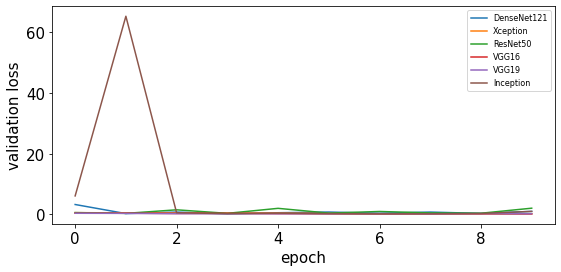

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_loss'])
plt.plot(xception_hist.history['val_loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.plot(vgg16_hist.history['val_loss'])
plt.plot(vgg19_hist.history['val_loss'])
plt.plot(inception_hist.history['val_loss'])
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

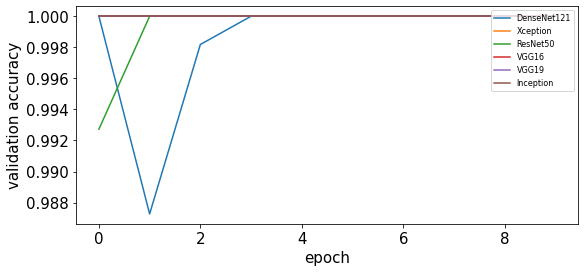

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_accuracy'])
plt.plot(xception_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(vgg16_hist.history['val_accuracy'])
plt.plot(vgg19_hist.history['val_accuracy'])
plt.plot(inception_hist.history['val_accuracy'])
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='upper right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

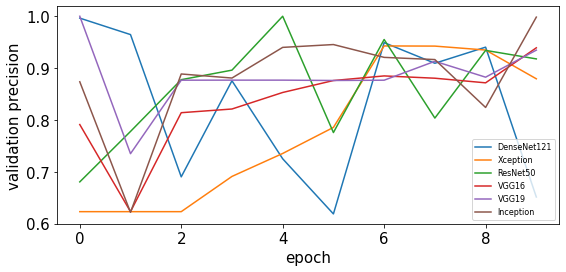

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_precision_1'])
plt.plot(xception_hist.history['val_precision_2'])
plt.plot(resnet_hist.history['val_precision_3'])
plt.plot(vgg16_hist.history['val_precision_4'])
plt.plot(vgg19_hist.history['val_precision_5'])
plt.plot(inception_hist.history['val_precision_6'])
plt.ylabel('validation precision')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='lower right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

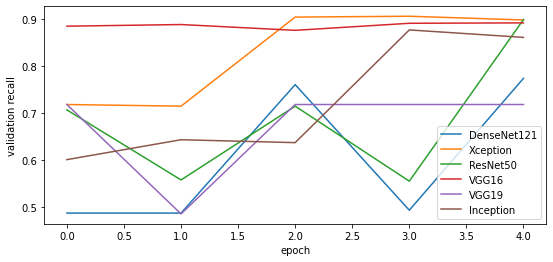

In [ ]:
# Plotting the loss functions of all the models.
plt.figure(figsize=(9,4))
plt.plot(denseNet_hist.history['val_recall_6'])
plt.plot(xception_hist.history['val_recall_7'])
plt.plot(resnet_hist.history['val_recall_8'])
plt.plot(vgg16_hist.history['val_recall_9'])
plt.plot(vgg19_hist.history['val_recall_10'])
plt.plot(inception_hist.history['val_recall_11'])
plt.ylabel('validation recall')
plt.xlabel('epoch')
plt.legend(['DenseNet121', 'Xception','ResNet50','VGG16', 'VGG19', 'Inception'], loc='lower right')
#plt.savefig('model_loss.pdf', bbox_inches='tight')
plt.show()

### Proposed Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.utils import np_utils
from sklearn import metrics

In [ ]:
# Checkpoint to save the best weights for Inception
checkpoint_filepath = filepath + '/custom_model.h5'
customModel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
def build_custom_model():
  with tf.device('/device:GPU:0'):
    model=Sequential()
    model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(224,224,3)))
    model.add(MaxPooling2D(padding="same"))

    model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
    model.add(MaxPooling2D(padding="same"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(layers.Flatten())

    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(5,activation='sigmoid'))
    
    model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(),
      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

In [ ]:
model = build_custom_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 128)       512       
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0

In [ ]:
def fit_custom_model(model):
  with tf.device('/device:GPU:0'):
    custom_model_history = model.fit(
        data_generator,
        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks = [customModel_checkpoint_callback]
    )
    return custom_model_history

In [ ]:
custom_hist = fit_custom_model(model)

Epoch 1/5
97/97 [==============================] - 76s 415ms/step - loss: 1.1573 - accuracy: 0.9656 - precision: 0.7979 - recall: 0.7860 - val_loss: 0.6817 - val_accuracy: 1.0000 - val_precision: 0.8822 - val_recall: 0.7399
Epoch 2/5
97/97 [==============================] - 40s 406ms/step - loss: 0.3935 - accuracy: 1.0000 - precision: 0.8132 - recall: 0.8554 - val_loss: 5.3585 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 0.4912
Epoch 3/5
97/97 [==============================] - 39s 395ms/step - loss: 0.3397 - accuracy: 1.0000 - precision: 0.8255 - recall: 0.8688 - val_loss: 0.3517 - val_accuracy: 1.0000 - val_precision: 0.8767 - val_recall: 0.8527
Epoch 4/5
97/97 [==============================] - 39s 396ms/step - loss: 0.3383 - accuracy: 1.0000 - precision: 0.8147 - recall: 0.8793 - val_loss: 1.2165 - val_accuracy: 1.0000 - val_precision: 0.9967 - val_recall: 0.5273
Epoch 5/5
97/97 [==============================] - 39s 401ms/step - loss: 0.3185 - accuracy: 1.0000 - pr

In [ ]:
def get_preds(arr):
    mask = arr == 0
    return np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

In [ ]:
preds = model.predict(x_val)

In [ ]:
preds

array([[1.0000000e+00, 9.6968189e-02, 7.4721880e-02, 1.4095784e-02,
        6.0176635e-03],
       [1.0000000e+00, 2.6478909e-07, 6.5700050e-08, 2.0811038e-08,
        9.5784693e-11],
       [9.9598002e-01, 7.5574434e-01, 6.0773057e-01, 2.0432378e-01,
        1.1969632e-01],
       ...,
       [9.9598002e-01, 7.5574434e-01, 6.0773057e-01, 2.0432378e-01,
        1.1969632e-01],
       [9.9598002e-01, 7.5574434e-01, 6.0773057e-01, 2.0432378e-01,
        1.1969632e-01],
       [9.9598002e-01, 7.5574434e-01, 6.0773057e-01, 2.0432378e-01,
        1.1969632e-01]], dtype=float32)

In [ ]:
accuracy_score(y_val_mod, get_preds((preds > 0.5)))

0.6854545454545454